In [33]:
import numpy as np

from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_distribution

# Algoritmo de Grover

## Algoritmo clássico

A busca em uma lista não ordenada possui complexidade de tempo no pior caso em $O(n)$, em média, se o elemento procurado está na lista é necessário aproximadamente $\frac{n}{2}$ comparações, sendo necessária uma comparação no melhor caso e $n$ comparações no pior caso.

Abaixo é apresentado um algoritmo que varre a lista do primeiro ao último elemento em busca do valor pesquisado, neste caso, o valor 7.

In [34]:
my_list = [1, 3, 5, 2, 4, 9, 5, 8, 0, 7, 6]

print(my_list)

def the_oracle(my_input):
    winner = 7
    return my_input is winner

for index, trial_number in enumerate(my_list):
    if the_oracle(trial_number) is True:
        print(f"Winner found at index {index}")
        print(f"{index+1} calls to Oracle used")
        break

[1, 3, 5, 2, 4, 9, 5, 8, 0, 7, 6]
Winner found at index 9
10 calls to Oracle used


## Algoritmo de Grover

### Introdução

O algoritmo de Grover é um algoritmo quântico que executa em tempo $O(\sqrt{N})$ (aproximadamente $\frac{\pi}{4}\sqrt{N}$ iterações), com $N$ a quantidade de elementos da lista.

Considere a lista abaixo:

In [35]:
my_new_list = [99, 4, -10, 5]
my_new_list

[99, 4, -10, 5]

No algoritmo de Grover precisamos implementar um oráculo para o valor pesquisado. Ao invés de modelarmos o oráculo para indentificar um valor, como no exemplo anterior, vamos utilizar um índice da lista, por exemplo, suponha que o valor que queremos é o 5, nosso objetivo então é construir um oráculo para identificar se o valor recebido é 3 (índice para o valor 5).

Como existem $N=4$ elementos na lista podemos modelar:

- Índice $0 = (1, 0, 0, 0) = \ket{00}$
- Índice $1 = (0, 1, 0, 0) = \ket{01}$
- Índice $2 = (0, 0, 1, 0) = \ket{10}$
- Índice $3 = (0, 0, 0, 1) = \ket{11}$

assim, o item procurado passa a ser o valor $\ket{\omega}=\ket{11}$ e precisamos de 2 qubits para o algoritmo.

Além disso, podemos calcular quantas iterações são necessárias para o algoritmo:

In [36]:
N = 4

iterations = (np.pi/4) * np.sqrt(N)

np.round(iterations, 2)

np.float64(1.57)

Logo, precisamos de somente uma iteração.

### Construção do oráculo

O código abaixo apresenta um exemplo de implementação do oráculo em sua versão clássica

In [37]:
def the_oracle(my_input):
    return my_input == 3

print(the_oracle(0))
print(the_oracle(1))
print(the_oracle(2))
print(the_oracle(3))

False
False
False
True


A versão quântica do oráculo é modelada como o operador unitário para 2 qubits $\operatorname{CZ_{0,1}}$ (qubit de controle $q_0$ e qubit alvo $q_1$).

Podemos nos perguntar:

por que a função `the_oracle` pode ser implementada desta forma?

No algoritmo de Grover o oráculo é responsável por "marcar" o estado desejado (inversão de fase) enquanto mantém os demais estados inalterados. Se aplicarmos $\operatorname{CZ_{0,1}}$ a cada um dos estados que representam os índices temos:

$$
\operatorname{CZ_{0,1}}\ket{q_1q_0} = \begin{cases}
    -\ket{q_1q_0}, & \text{se } q_0=1,q_1=1 \\
    \phantom{-}\ket{q_1q_0}, & \text{caso contrário}
    \end{cases}
$$


- $\operatorname{CZ_{0,1}}\ket{00} = \ket{00}$
- $\operatorname{CZ_{0,1}}\ket{01} = \ket{01}$
- $\operatorname{CZ_{0,1}}\ket{10} = \ket{10}$
- $\operatorname{CZ_{0,1}}\ket{11} = -\ket{11}$

Em geral, sendo $\omega$ o índice procurado

$$
U_{\omega} \ket{x} = \begin{cases}
    -\ket{x}, & \text{se } x = \omega \\
    \phantom{-}\ket{x}, & \text{caso contrário}
    \end{cases}
$$

Que pode ser construído usando o operador
$$
U_{\omega} = I - 2\ket{\omega}\bra{\omega},
$$
por exemplo, ao aplicarmos no estado procurado $\ket{\omega}$
$$
U_{\omega}(\ket{\omega}) = (I-2\ket{\omega}\bra{\omega})(\ket{\omega}) = I\ket{\omega} -2\braket{\omega|\omega}\ket{\omega} = \ket{\omega} - 2\ket{\omega} = -\ket{\omega},
$$
e $\ket{x_i}$, $x_i \neq \omega$

$$
U_{\omega}(\ket{x_i}) = (I-2\ket{\omega}\bra{\omega})(\ket{x_i}) = I\ket{x_i} -2\cancel{\braket{\omega|x_i}}^0\ket{\omega} = \ket{x_i}.
$$

Temos então o oráculo:

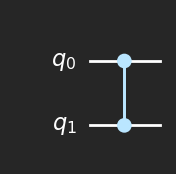

In [38]:
oracle = QuantumCircuit(2, name="Uω")
oracle.cz(0,1)

# m1 = sp.Matrix(Operator(oracle).data)
# m1

oracle.draw("mpl", style="iqp-dark")

Após construção do oráculo, inicializamos o sistema como uma superposição uniforme de todos os estados

$$
\ket{s} = \frac{1}{\sqrt{N}}\sum_{x=0}^{N-1}\ket{x}.
$$
No nosso caso,
$$
\ket{s} = \frac{1}{2}(\ket{00}+\ket{01}+\ket{10}+\ket{11}).
$$
Isso pode ser feito aplicando o operador de Hadamard em em todos os qubits. Após a aplicação do operador de Hadamard, adicionamos o circuito criado para o oráculo no novo circuito

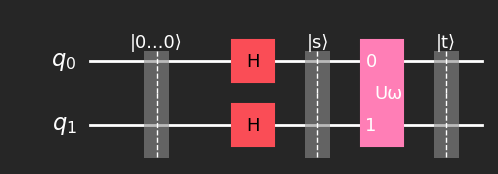

In [39]:
grover_circ = QuantumCircuit(2)

grover_circ.barrier(label="|0...0⟩")
grover_circ.h([0,1])
grover_circ.barrier(label="|s⟩")
grover_circ.append(oracle, [0,1])
grover_circ.barrier(label="|t⟩")

grover_circ.draw("mpl", style="iqp-dark")

Após a aplicação do oráculo temos o estado
$$
\ket{t} = \frac{1}{2}(\ket{00}+\ket{01}+\ket{10}-\ket{11})
$$

Vamos construir o circuito de difusão (ou reflexão). Sua forma geral é dada por
$$
U_s = 2\ket{s}\bra{s} - I,
$$
$U_s$ é a reflexão no eixo dado por $\ket{s}$.

No nosso cenário temos
$$
\begin{align*}
    U_s(\ket{t}) &= (2\ket{s}\bra{s} - I)(\ket{t})    \\
                  &= 2\braket{s|t}\ket{s} - \ket{t}   \\
                  &= \frac{1}{2}(\braket{00|00} + \braket{01|01}+ \cancel{\braket{10|10}} - \cancel{\braket{11|11}})\ket{s} - \ket{t} \\
                  &= \ket{s} - \ket{t} \\
                  &= \frac{1}{2}(\cancel{\ket{00}}+\cancel{\ket{01}}+\cancel{\ket{10}}+\ket{11}) - \frac{1}{2}(\cancel{\ket{00}}+\cancel{\ket{01}}+\cancel{\ket{10}}-\ket{11}) \\
                  &= \ket{11}
\end{align*}.
$$

Como calculamos anteriormente, apenas uma iteração, ou seja, uma aplicação do operador $\operatorname{U_sU_{\omega}}$ é necessária para chegar ao valor procurado.

Para nosso caso, temos $\operatorname{U_s}=\operatorname{H^{\otimes^2}}\cdot\operatorname{CZ_{0,1}}\cdot\operatorname{Z^{\otimes^2}}\cdot\operatorname{H^{\otimes^2}}$


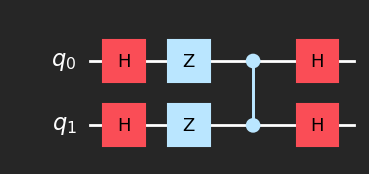

In [40]:
diffusion = QuantumCircuit(2, name='Us')

diffusion.h([0,1])
diffusion.z([0,1])
diffusion.cz(0,1)
diffusion.h([0,1])

diffusion.draw("mpl", style="iqp-dark")

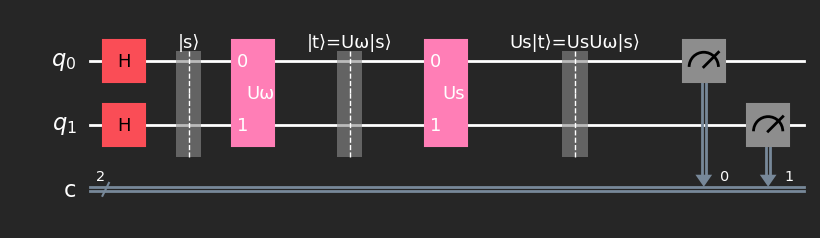

In [41]:
grover_circ = QuantumCircuit(2,2)
grover_circ.h([0,1])
grover_circ.barrier(label="|s⟩")
grover_circ.append(oracle, [0,1])
grover_circ.barrier(label="|t⟩=Uω|s⟩")
grover_circ.append(diffusion, [0,1])
grover_circ.barrier(label="Us|t⟩=UsUω|s⟩")
grover_circ.measure([0,1], [0,1])

grover_circ.draw("mpl", style="iqp-dark")

O circuito completo, expandido o oráculo e a reflexão pode ser visto a seguir

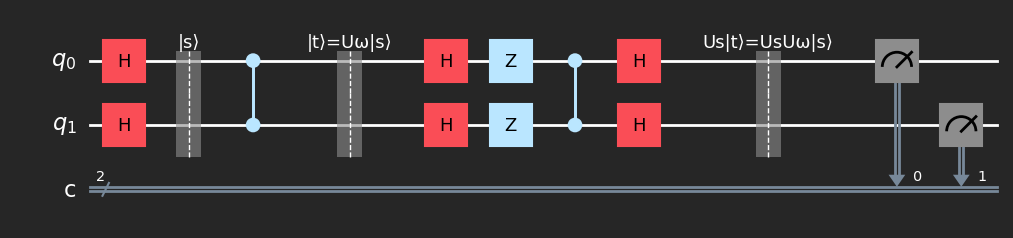

In [42]:
grover_circ.decompose(gates_to_decompose=["Uω", "Us"]).draw(output="mpl", style="iqp-dark")

Com o circuito completo podemos realizar as simulações utilizando um dos [simuladores](https://qiskit.github.io/qiskit-aer/tutorials/1_aersimulator.html) disponíveis.

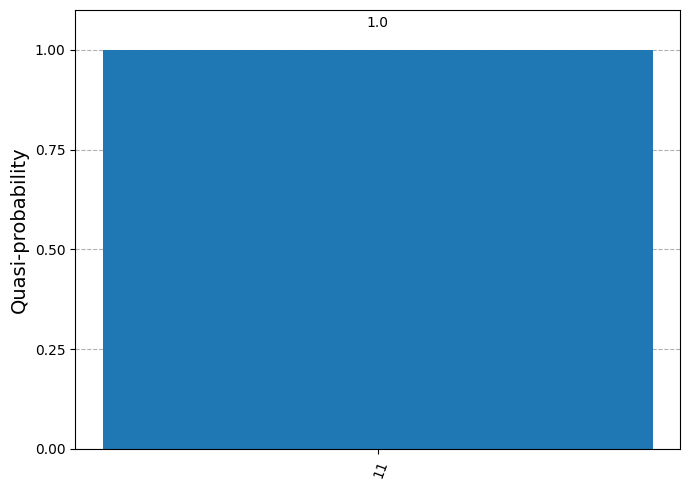

In [43]:
sim_statevector = AerSimulator(method='statevector')
grover_circ = transpile(grover_circ, sim_statevector)

job_statevector = sim_statevector.run(grover_circ, shots=10000)
dist = job_statevector.result().get_counts()

plot_distribution(dist)

### Considerações

sendo $\ket{\omega}$ e $\ket{s}$ conforme apresentados anteriormente, podemos tomar $\ket{s'}$ um vetor unitário no plano dado por $\ket{w}$ e $\ket{s}$ tal que $\ket{s'}\perp \ket{\omega}$, ou seja,
$$
\ket{s'} = \frac{1}{\sqrt{N-1}}\sum_{x\neq \omega} \ket{x},
$$
para nosso exemplo,
$$
\ket{s'} = \frac{1}{\sqrt{3}}(\ket{00}+\ket{01}+\ket{10}),
$$
$$
\braket{s|\omega} = \braket{s|11} = 0
$$
e
$$
\braket{s|s'} = \frac{N-1}{\sqrt{N(N-1)}} = \sqrt{\frac{N-1}{N}}.
$$

O ângulo $\alpha = \theta/2$ entre $\ket{s'}$ e $\ket{s}$ é dado por
$$
\braket{s|s'} = \cancel{||s||\cdot||s'||}^1\cdot \cos(\alpha) = \cos\bigg(\frac{\theta}{2}\bigg) = \sqrt{\frac{N-1}{N}} \implies \sin\bigg(\frac{\theta}{2}\bigg) = \frac{1}{\sqrt{N}}
$$

*(TODO: demonstrar número de iterações necessárias $\approx \frac{\pi}{4}\sqrt{N}$)*

## Referências

- [Wikipedia - Grover's Algorithm](https://en.wikipedia.org/wiki/Grover%27s_algorithm)
- [Grovers Algorithm — Programming on Quantum Computers](https://www.youtube.com/watch?v=0RPFWZj7Jm0)
- [Simuladores do Qiskit](https://qiskit.github.io/qiskit-aer/tutorials/1_aersimulator.html)
- [IBM - Grover's algorithm](https://quantum.cloud.ibm.com/docs/en/tutorials/grovers-algorithm)
- [2-Bit Example of Grover's Quantum Search Algorithm, Geometric Visualization, Quantum Circuit Diagram](https://www.youtube.com/watch?v=PJorOzsQ7FU)
- [Mas o que é computação quântica? (Algoritmo de Grover)](https://www.youtube.com/watch?v=RQWpF2Gb-gU)